In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier  
from matplotlib.colors import ListedColormap  
from sklearn.datasets import make_classification

# Loading the Data and preview

In [2]:
data = pd.read_csv('Telco-Customer-Churn.csv',sep=",")  
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.shape

(7043, 21)

In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# data Cleaning and outlinier detection

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#binary encoding of categorical variables
varlist =  ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']

def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

data[varlist] = data[varlist].apply(binary_map)

In [7]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [8]:
#conversion of data into correct datatypes
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [9]:
#identifying all numerical data columns
num_data = data[['tenure','MonthlyCharges','TotalCharges']]

In [10]:
num_data.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
90%,69.000000,102.600000,5976.640000
95%,72.000000,107.400000,6923.590000
99%,72.000000,114.729000,8039.883000


# Univariate Analysis

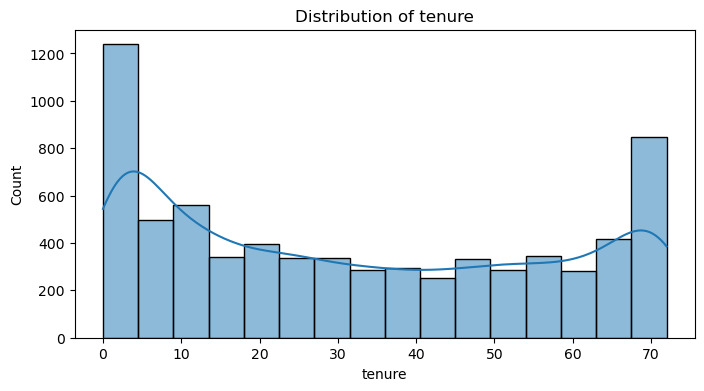

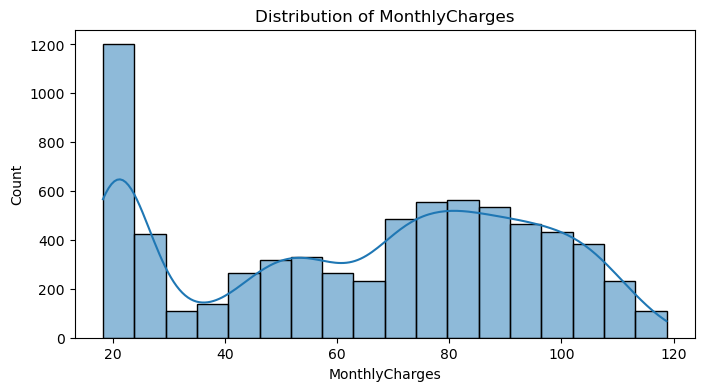

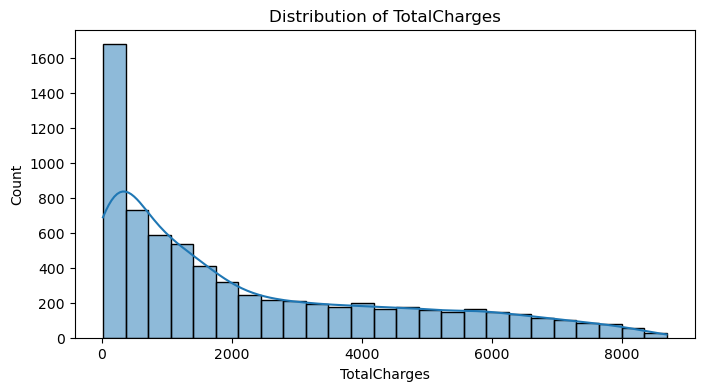

In [11]:
for feature in num_data:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


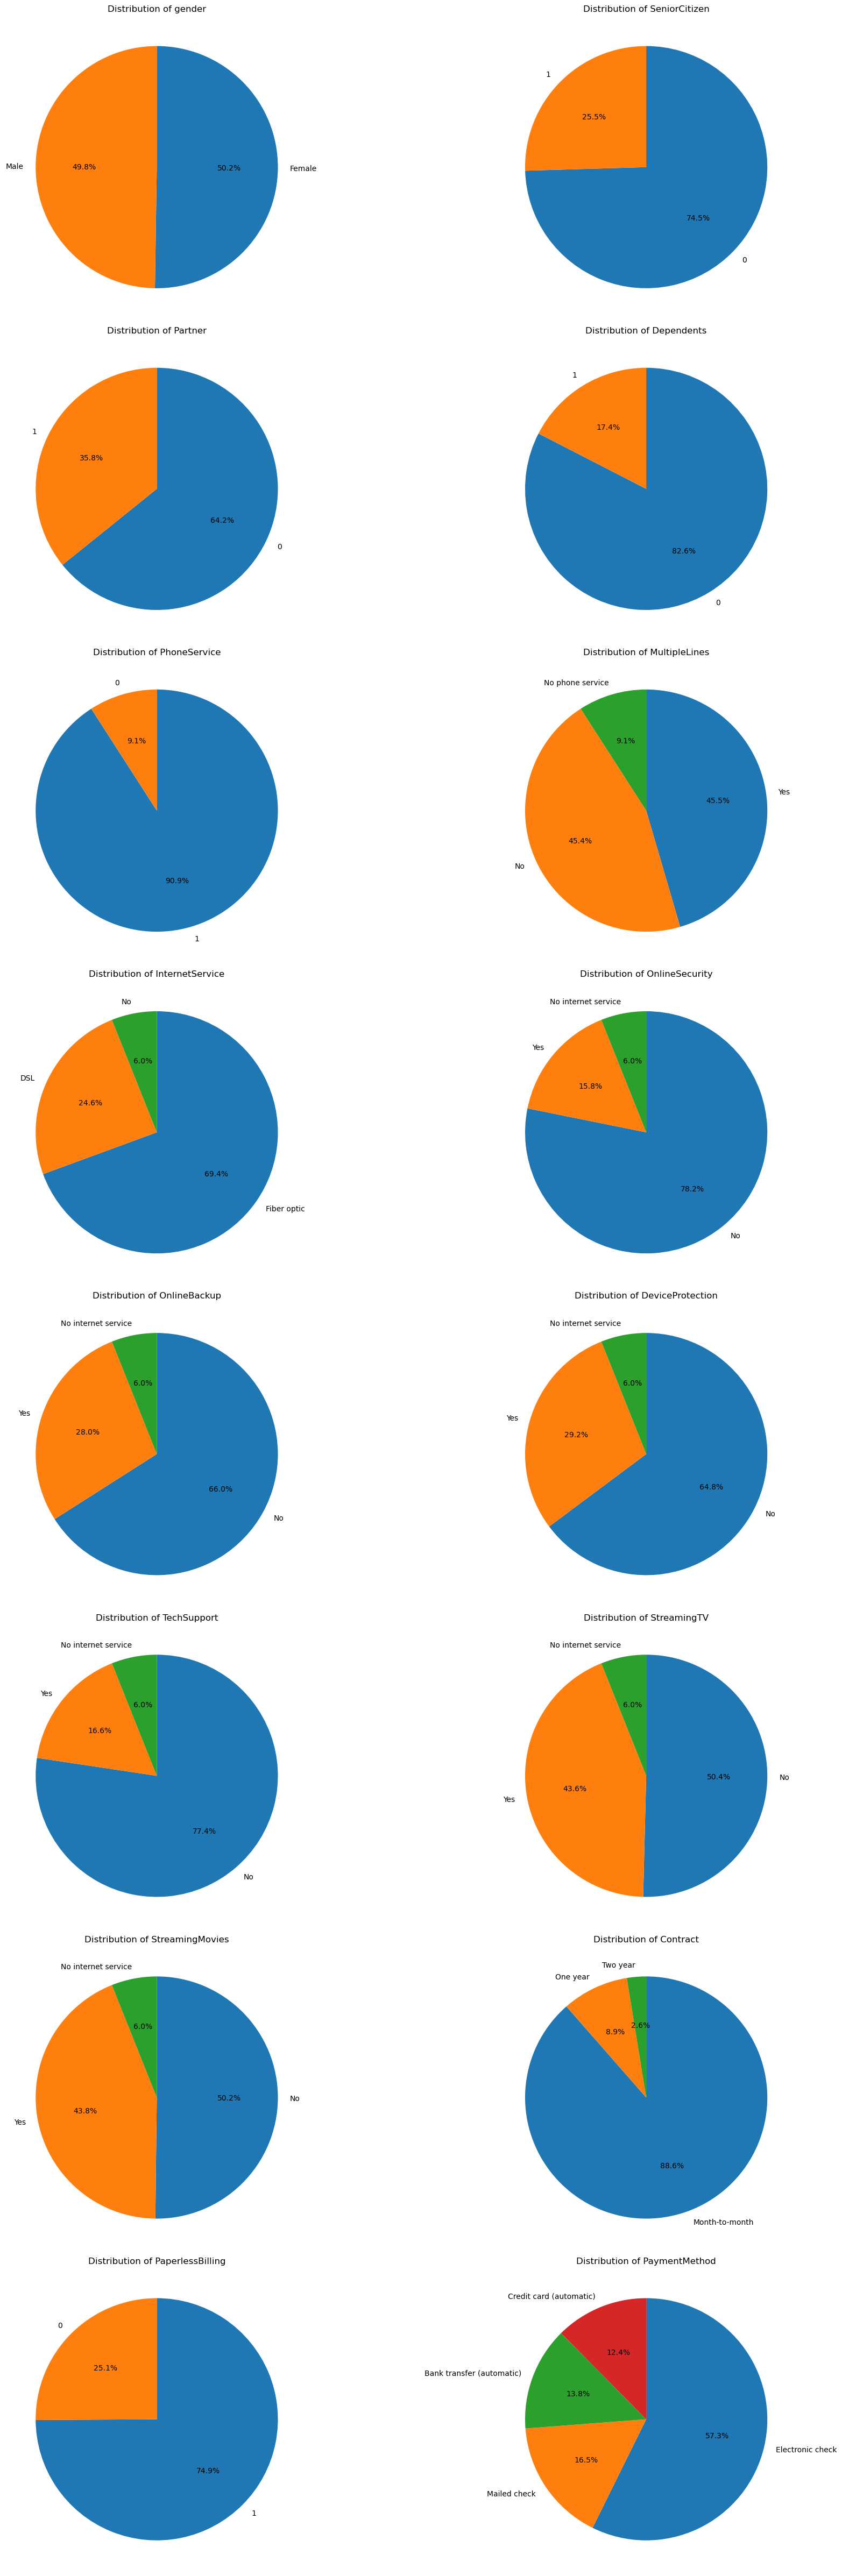

In [12]:
churn_data = data[data["Churn"] == 1]
# Categorical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# Determine the number of rows and columns for the grid
num_features = len(categorical_features)
num_cols = 2  # Set the number of columns in the grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, feature in enumerate(categorical_features):
    churn_data[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_ylabel('')  # Remove the y-label for better appearance



plt.tight_layout()
plt.show()

# Bivariate Analysis

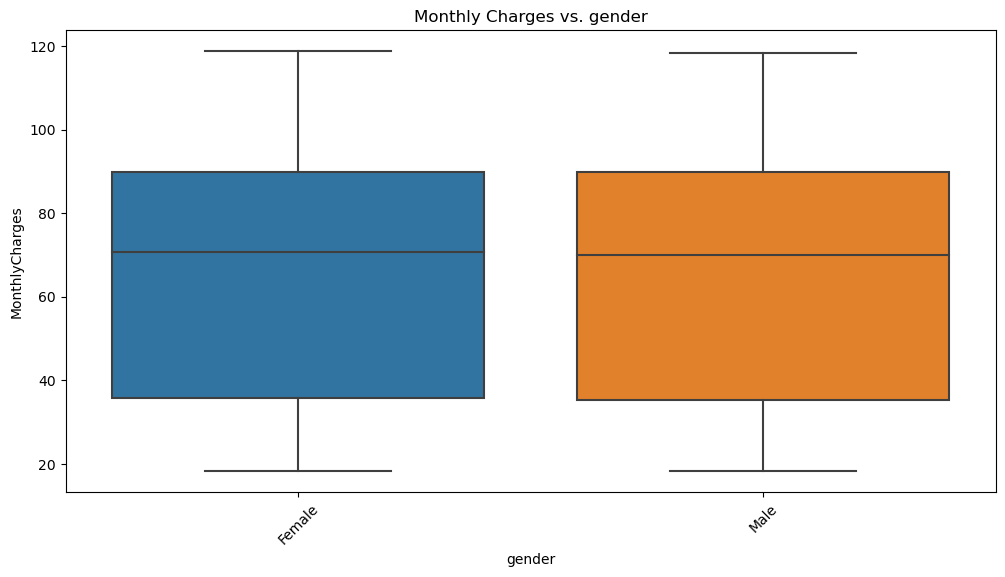

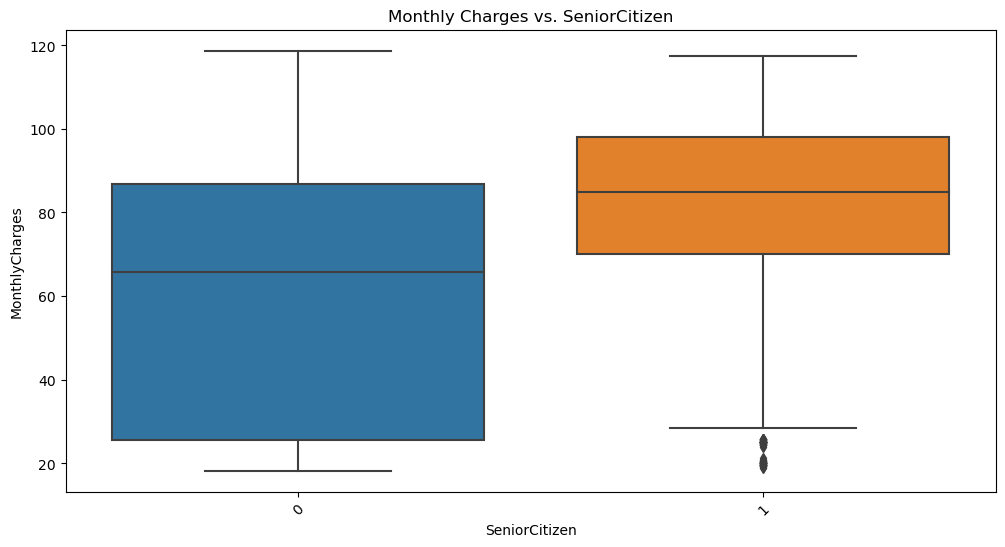

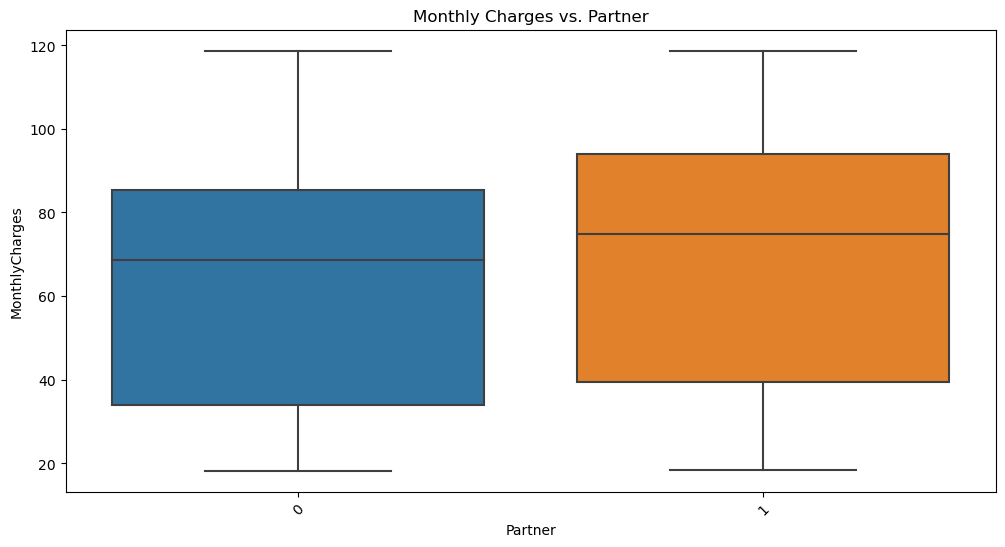

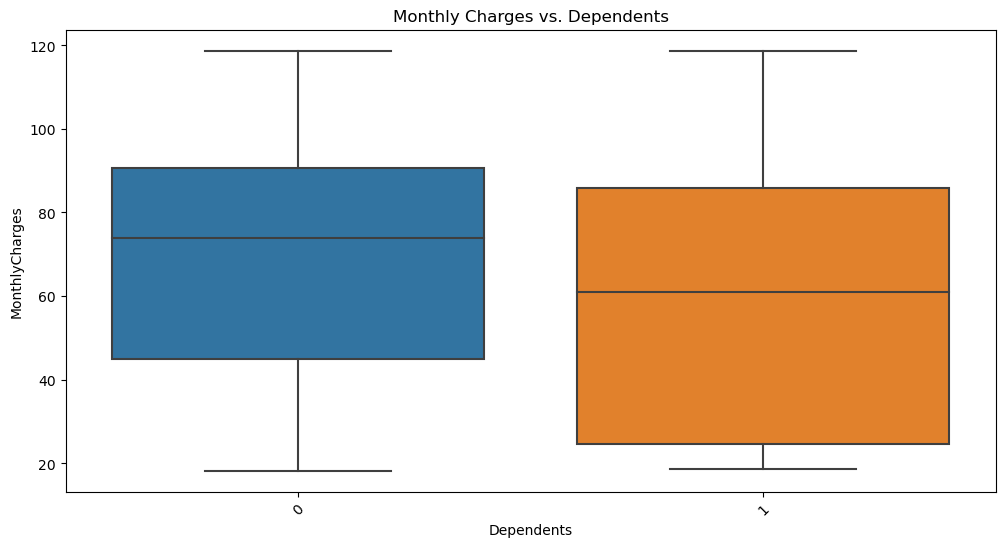

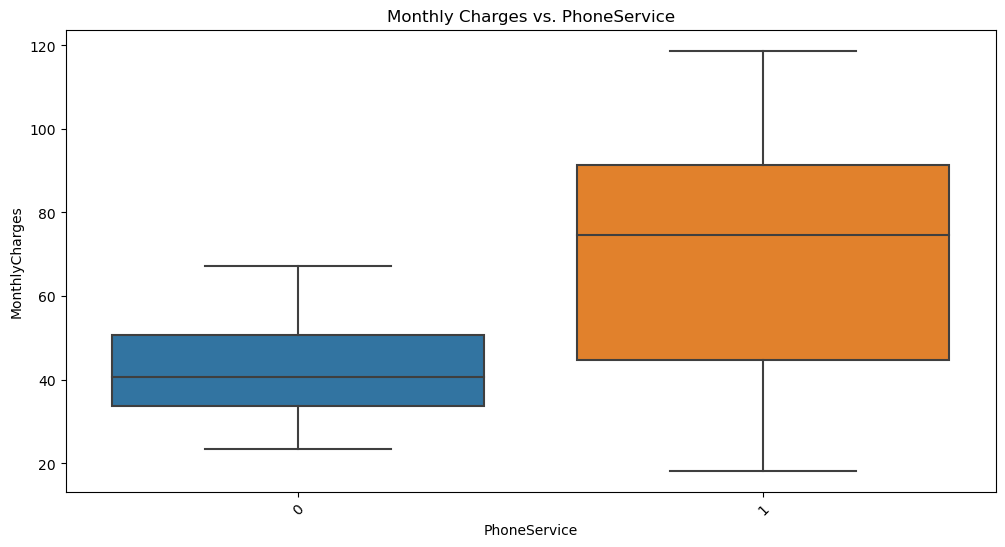

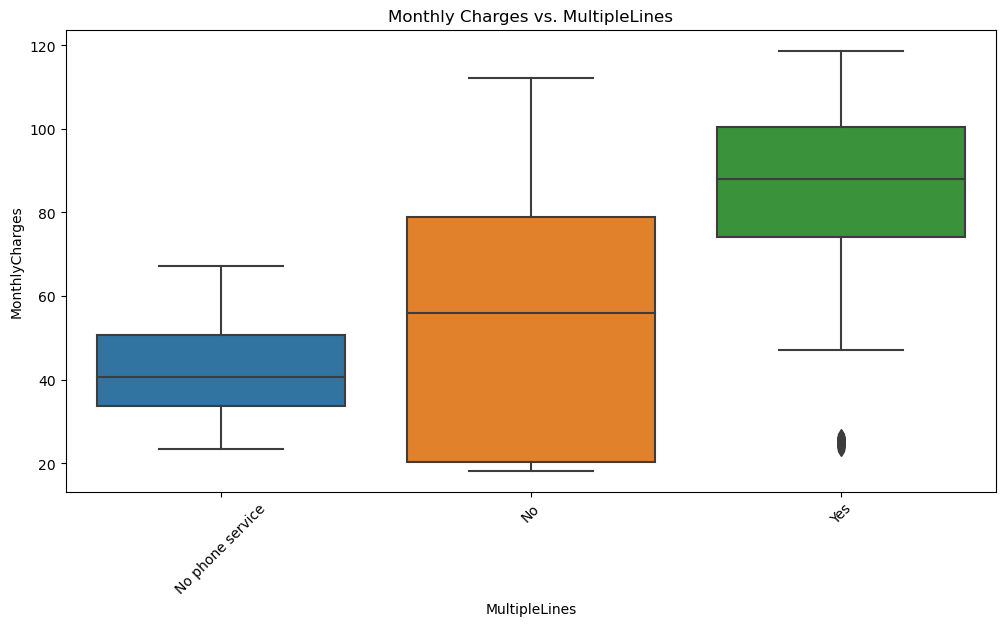

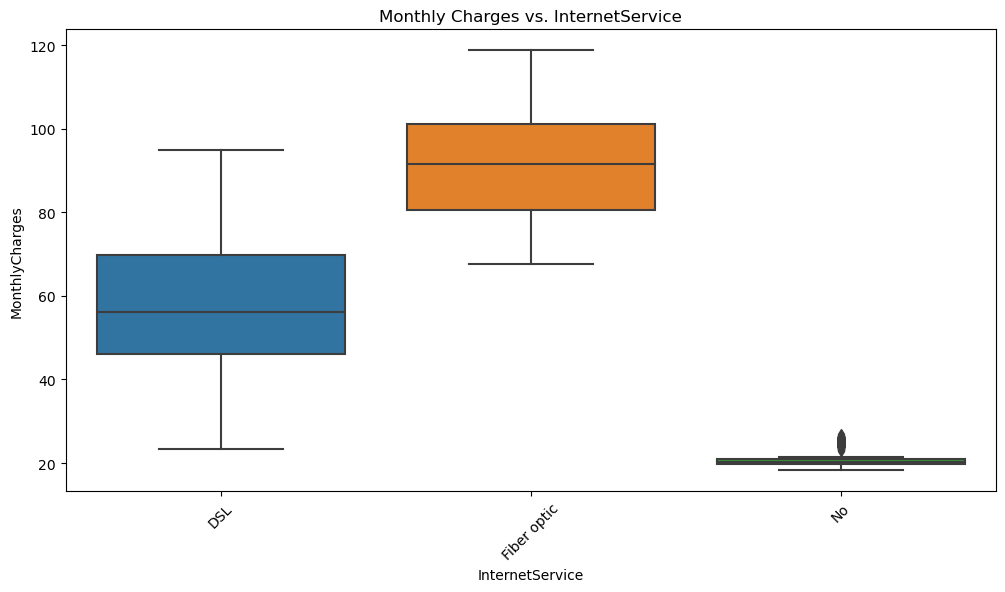

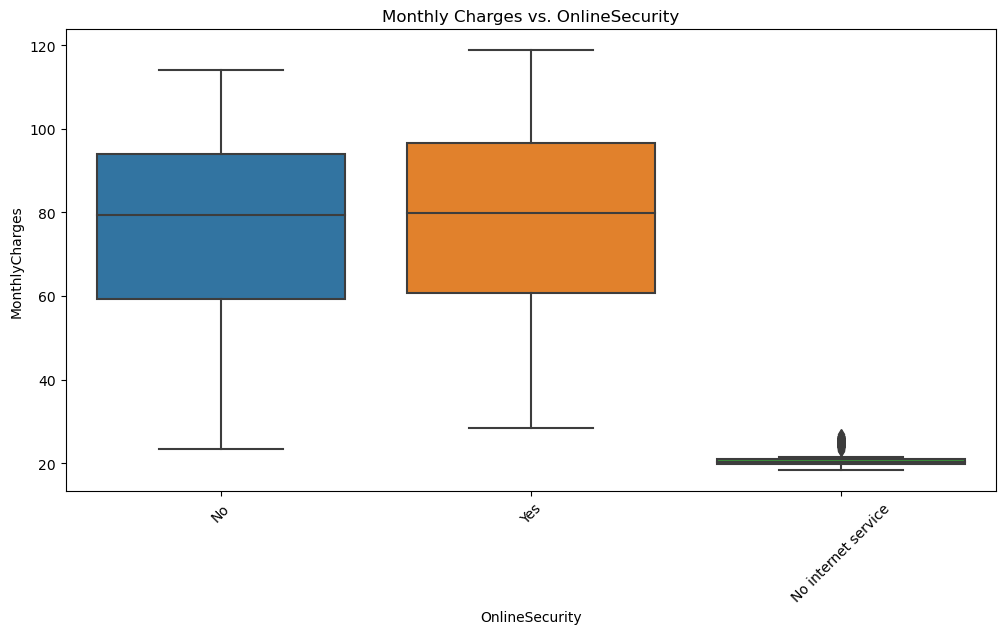

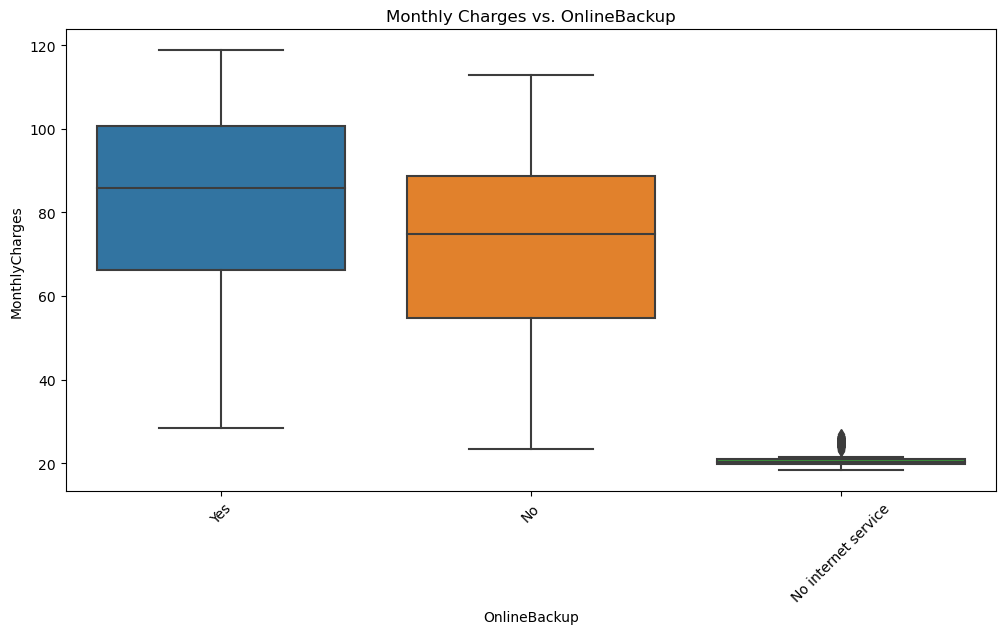

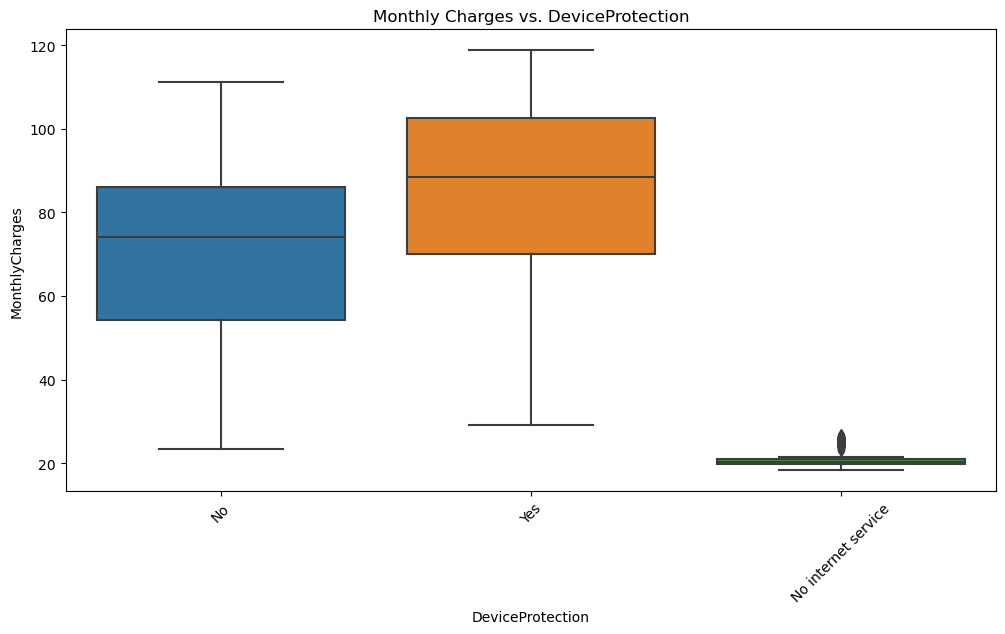

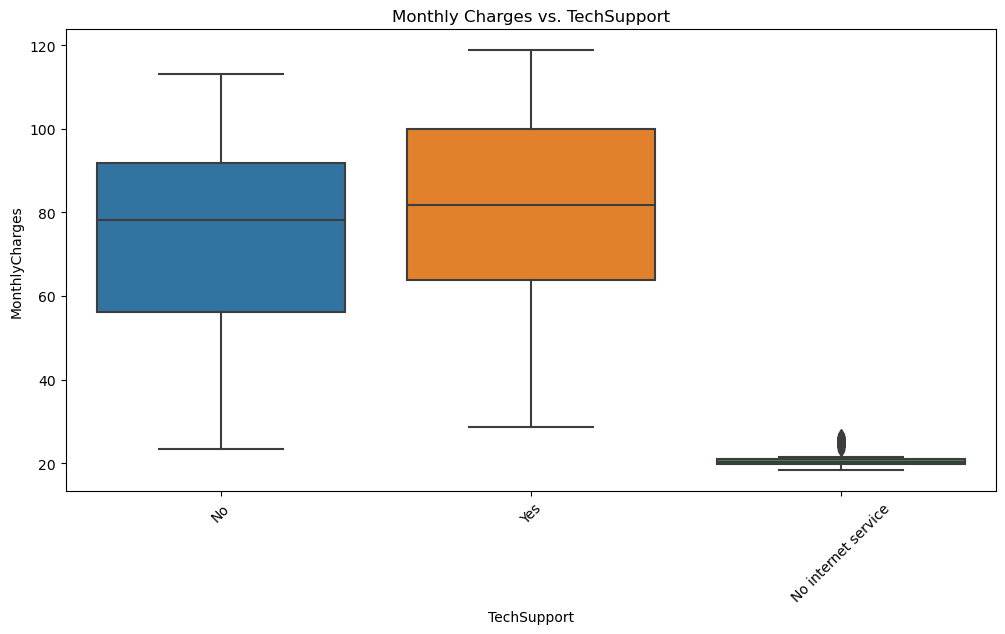

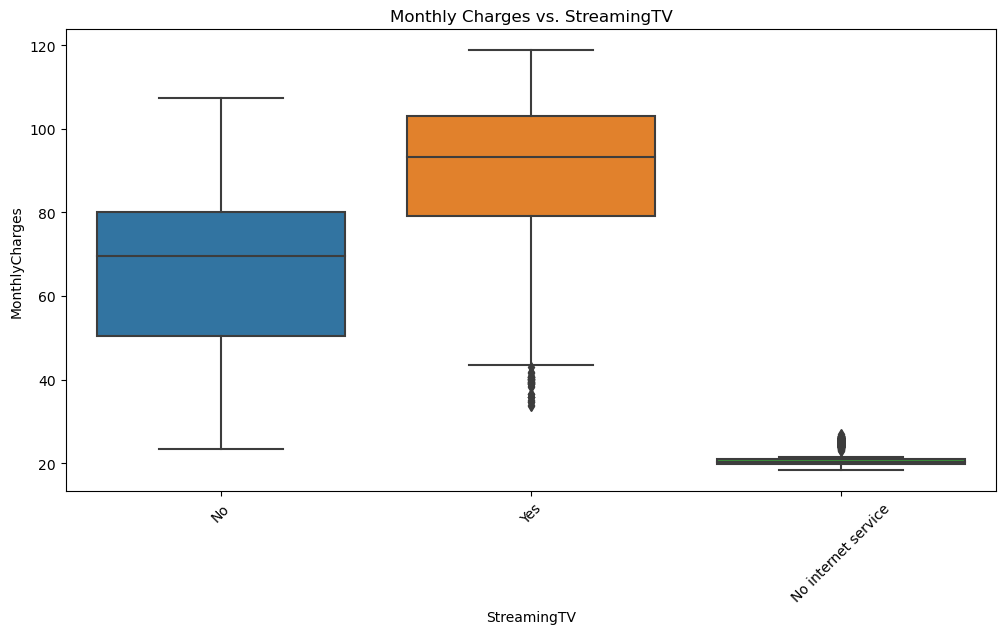

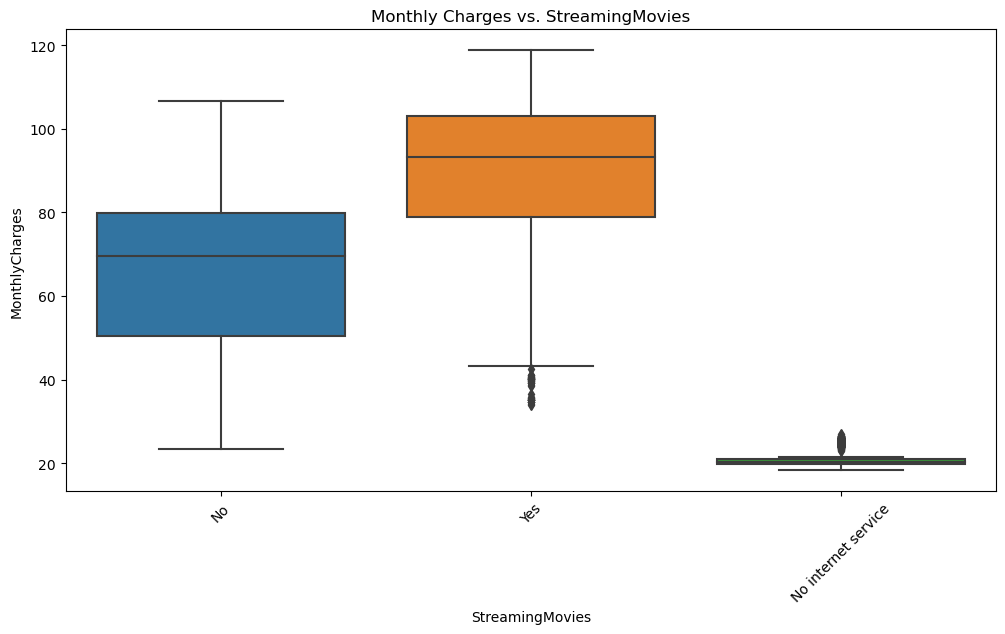

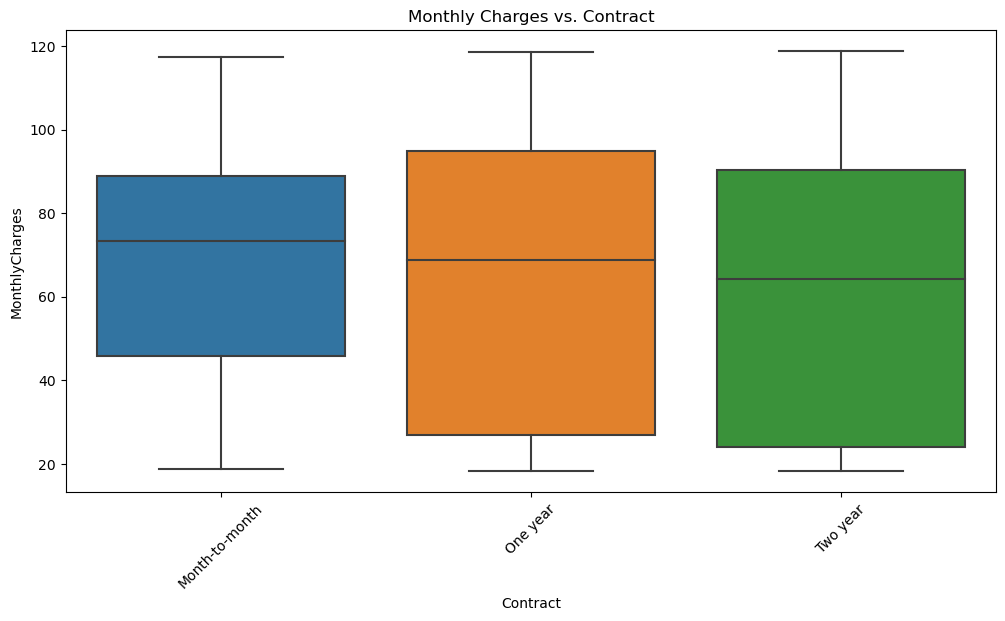

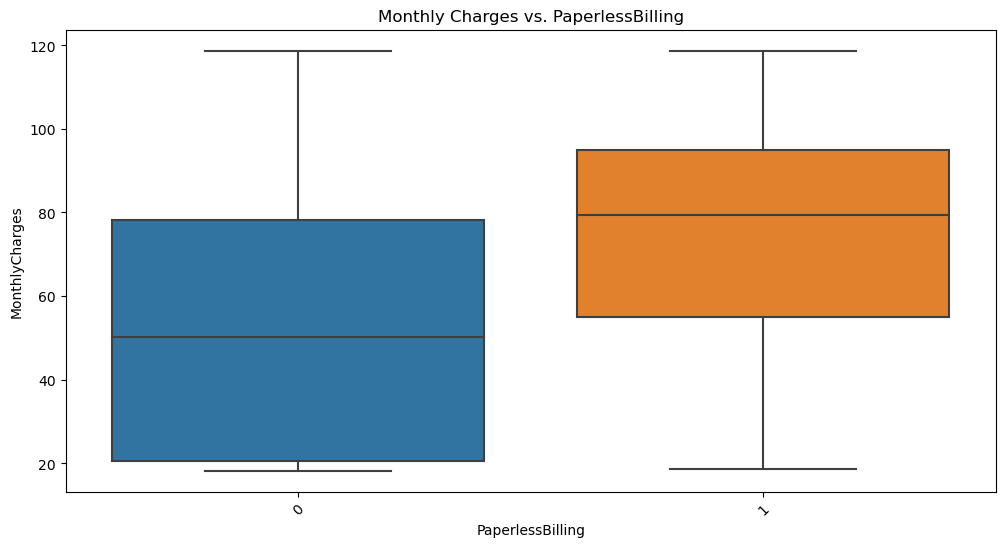

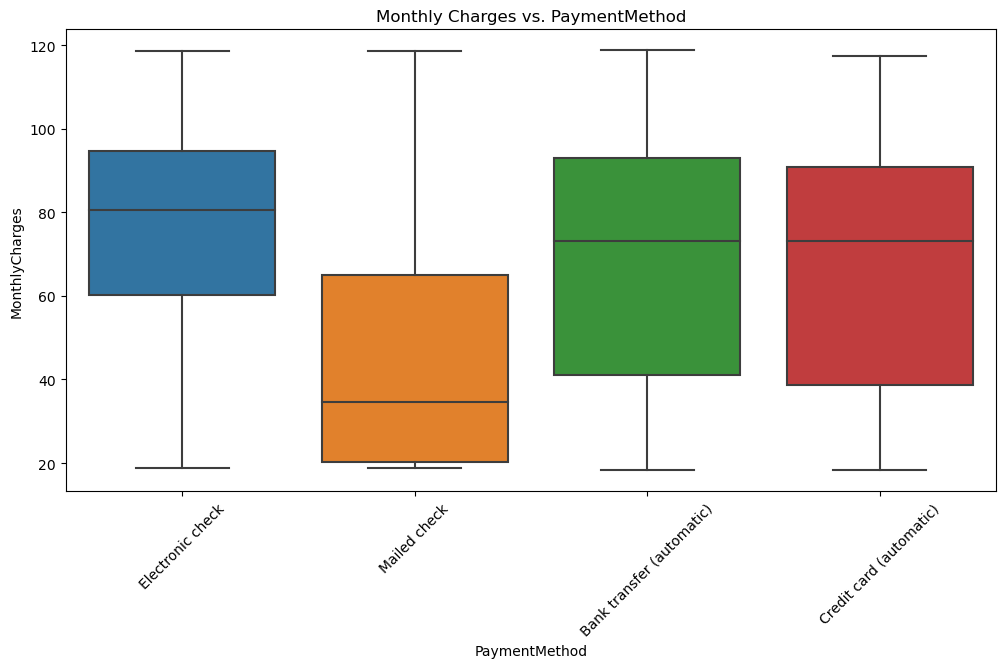

In [13]:
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x=feature, y='MonthlyCharges')
    plt.title(f'Monthly Charges vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('MonthlyCharges')
    plt.xticks(rotation=45)
    plt.show()


# Multivariate Analysis

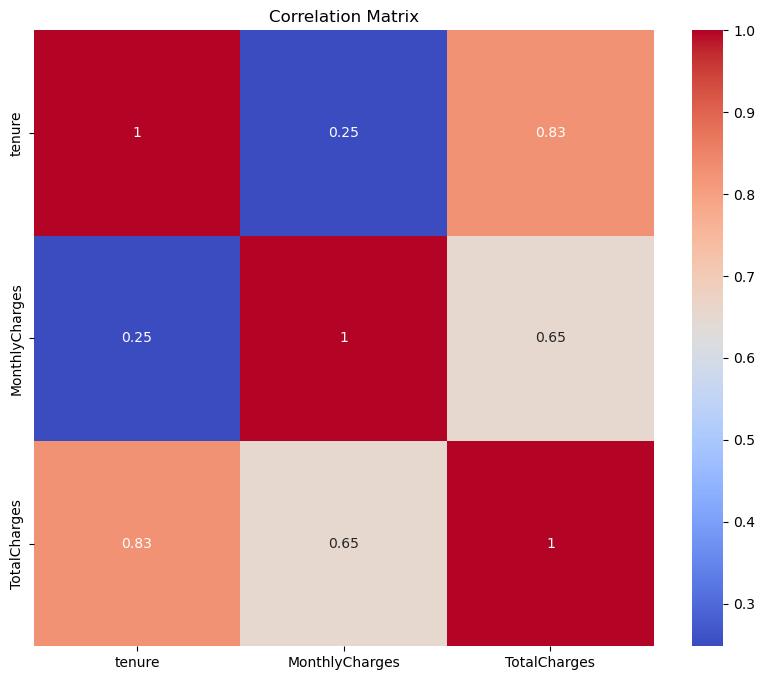

In [14]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(num_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


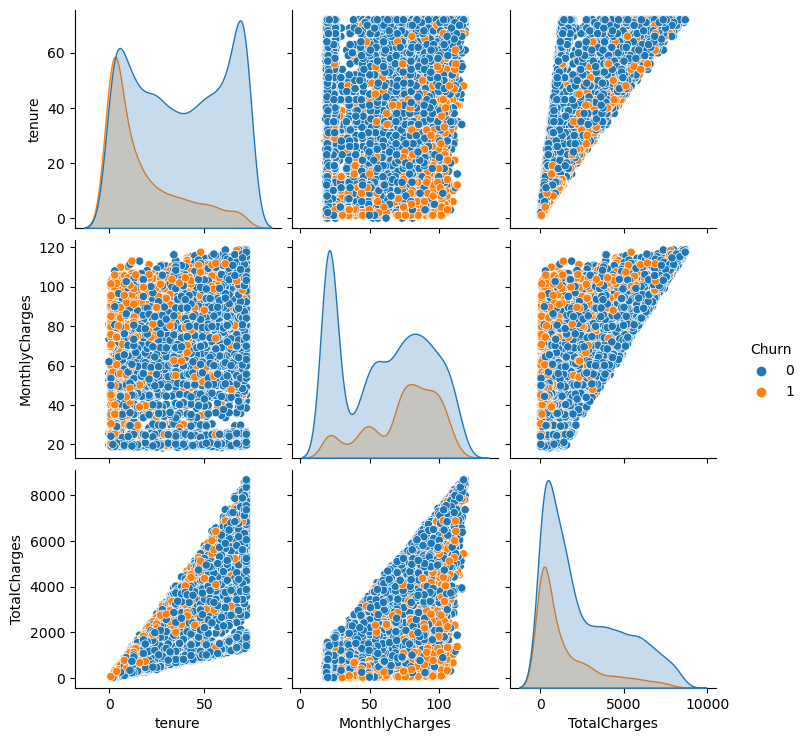

In [15]:
# Select a subset of features for pair plot
selected_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
sns.pairplot(data[selected_features], hue='Churn')
plt.show()


# Feature Engineering

In [16]:
dummy1 = pd.get_dummies(data[['Contract', 'PaymentMethod', 'gender', 'InternetService']], drop_first=True)

data = pd.concat([data, dummy1], axis=1)

In [17]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,29.85,0,0,0,0,1,0,0,0,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,1889.50,0,1,0,0,0,1,1,0,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,108.15,1,0,0,0,0,1,1,0,0
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,1840.75,0,1,0,0,0,0,1,0,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,151.65,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,1,1,24,1,Yes,DSL,Yes,...,1990.50,0,1,0,0,0,1,1,0,0
7039,2234-XADUH,Female,0,1,1,72,1,Yes,Fiber optic,No,...,7362.90,0,1,0,1,0,0,0,1,0
7040,4801-JZAZL,Female,0,1,1,11,0,No phone service,DSL,Yes,...,346.45,0,0,0,0,1,0,0,0,0
7041,8361-LTMKD,Male,1,1,0,4,1,Yes,Fiber optic,No,...,306.60,1,0,0,0,0,1,1,1,0


In [18]:
data["OnlineBackup"].astype("category").value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [19]:
# Creating dummy variables for the variable 'MultipleLines'
ml = pd.get_dummies(data['MultipleLines'], prefix='MultipleLines')
# Dropping MultipleLines_No phone service column
ml1 = ml.drop(['MultipleLines_No phone service'], 1)
#Adding the results to the master dataframe
data = pd.concat([data,ml1], axis=1)


# Creating dummy variables for the variable 'OnlineSecurity'.
os = pd.get_dummies(data['OnlineSecurity'], prefix='OnlineSecurity')
os1 = os.drop(['OnlineSecurity_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,os1], axis=1)


# Creating dummy variables for the variable 'OnlineBackup'.
ob = pd.get_dummies(data['OnlineBackup'], prefix='OnlineBackup')
ob1 = ob.drop(['OnlineBackup_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,ob1], axis=1)


# Creating dummy variables for the variable 'DeviceProtection'. 
dp = pd.get_dummies(data['DeviceProtection'], prefix='DeviceProtection')
dp1 = dp.drop(['DeviceProtection_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,dp1], axis=1)

# Creating dummy variables for the variable 'TechSupport'. 
ts = pd.get_dummies(data['TechSupport'], prefix='TechSupport')
ts1 = ts.drop(['TechSupport_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,ts1], axis=1)


# Creating dummy variables for the variable 'StreamingTV'.
st =pd.get_dummies(data['StreamingTV'], prefix='StreamingTV')
st1 = st.drop(['StreamingTV_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,st1], axis=1)


# Creating dummy variables for the variable 'StreamingMovies'. 
sm = pd.get_dummies(data['StreamingMovies'], prefix='StreamingMovies')
sm1 = sm.drop(['StreamingMovies_No internet service'], 1)
# Adding the results to the master dataframe
data = pd.concat([data,sm1], axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1724372074.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ml1 = ml.drop(['MultipleLines_No phone service'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1724372074.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  os1 = os.drop(['OnlineSecurity_No internet service'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1724372074.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ob1 = ob.drop(['OnlineBackup_No internet service'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1724372074.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dp1 = dp.drop(['DeviceProtection_No inte

In [20]:
data = data.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'], 1)

C:\Users\hp\AppData\Local\Temp\ipykernel_20152\2932725001.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7032 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

In [22]:
# Adding up the missing values (column-wise)
data.isnull().sum()

customerID                                0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
Contract_One year                         0
Contract_Two year                         0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
InternetService_Fiber optic               0
InternetService_No                        0
MultipleLines_No                          0
MultipleLines_Yes                         0
OnlineSecurity_No                         0
OnlineSecurity_Yes                        0
OnlineBackup_No                 

In [23]:
round(100*(data.isnull().sum()/len(data.index)), 2)

customerID                               0.00
SeniorCitizen                            0.00
Partner                                  0.00
Dependents                               0.00
tenure                                   0.00
PhoneService                             0.00
PaperlessBilling                         0.00
MonthlyCharges                           0.00
TotalCharges                             0.16
Churn                                    0.00
Contract_One year                        0.00
Contract_Two year                        0.00
PaymentMethod_Credit card (automatic)    0.00
PaymentMethod_Electronic check           0.00
PaymentMethod_Mailed check               0.00
gender_Male                              0.00
InternetService_Fiber optic              0.00
InternetService_No                       0.00
MultipleLines_No                         0.00
MultipleLines_Yes                        0.00
OnlineSecurity_No                        0.00
OnlineSecurity_Yes                

In [24]:
data = data[~np.isnan(data['TotalCharges'])]

In [25]:
round(100*(data.isnull().sum()/len(data.index)), 2)

customerID                               0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBack

# Churn Analysis or Churn Rate

In [26]:
churn = (sum(data['Churn'])/len(data['Churn'].index))*100
churn

26.578498293515356

# Scaling and training of Logistic Regression Model

In [27]:
y = data["Churn"]
X = data.drop(["Churn", "customerID"],1)

C:\Users\hp\AppData\Local\Temp\ipykernel_20152\3821465299.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop(["Churn", "customerID"],1)


In [28]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [29]:
#scaling of data
scaler = MinMaxScaler()

X_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])

X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
879,0,0,0,0.450704,1,1,0.362189,0.189979,0,0,...,0,1,1,0,1,0,1,0,1,0
5790,0,1,1,0.549296,0,1,0.324378,0.232831,0,0,...,0,1,1,0,1,0,0,1,0,1
6498,0,0,0,0.000000,1,1,0.637313,0.007322,0,0,...,0,1,0,1,1,0,1,0,1,0
880,0,0,0,0.126761,1,1,0.913930,0.118216,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,0,0,1,0.042254,1,1,0.794527,0.043556,0,0,...,1,0,0,1,0,1,0,1,0,1


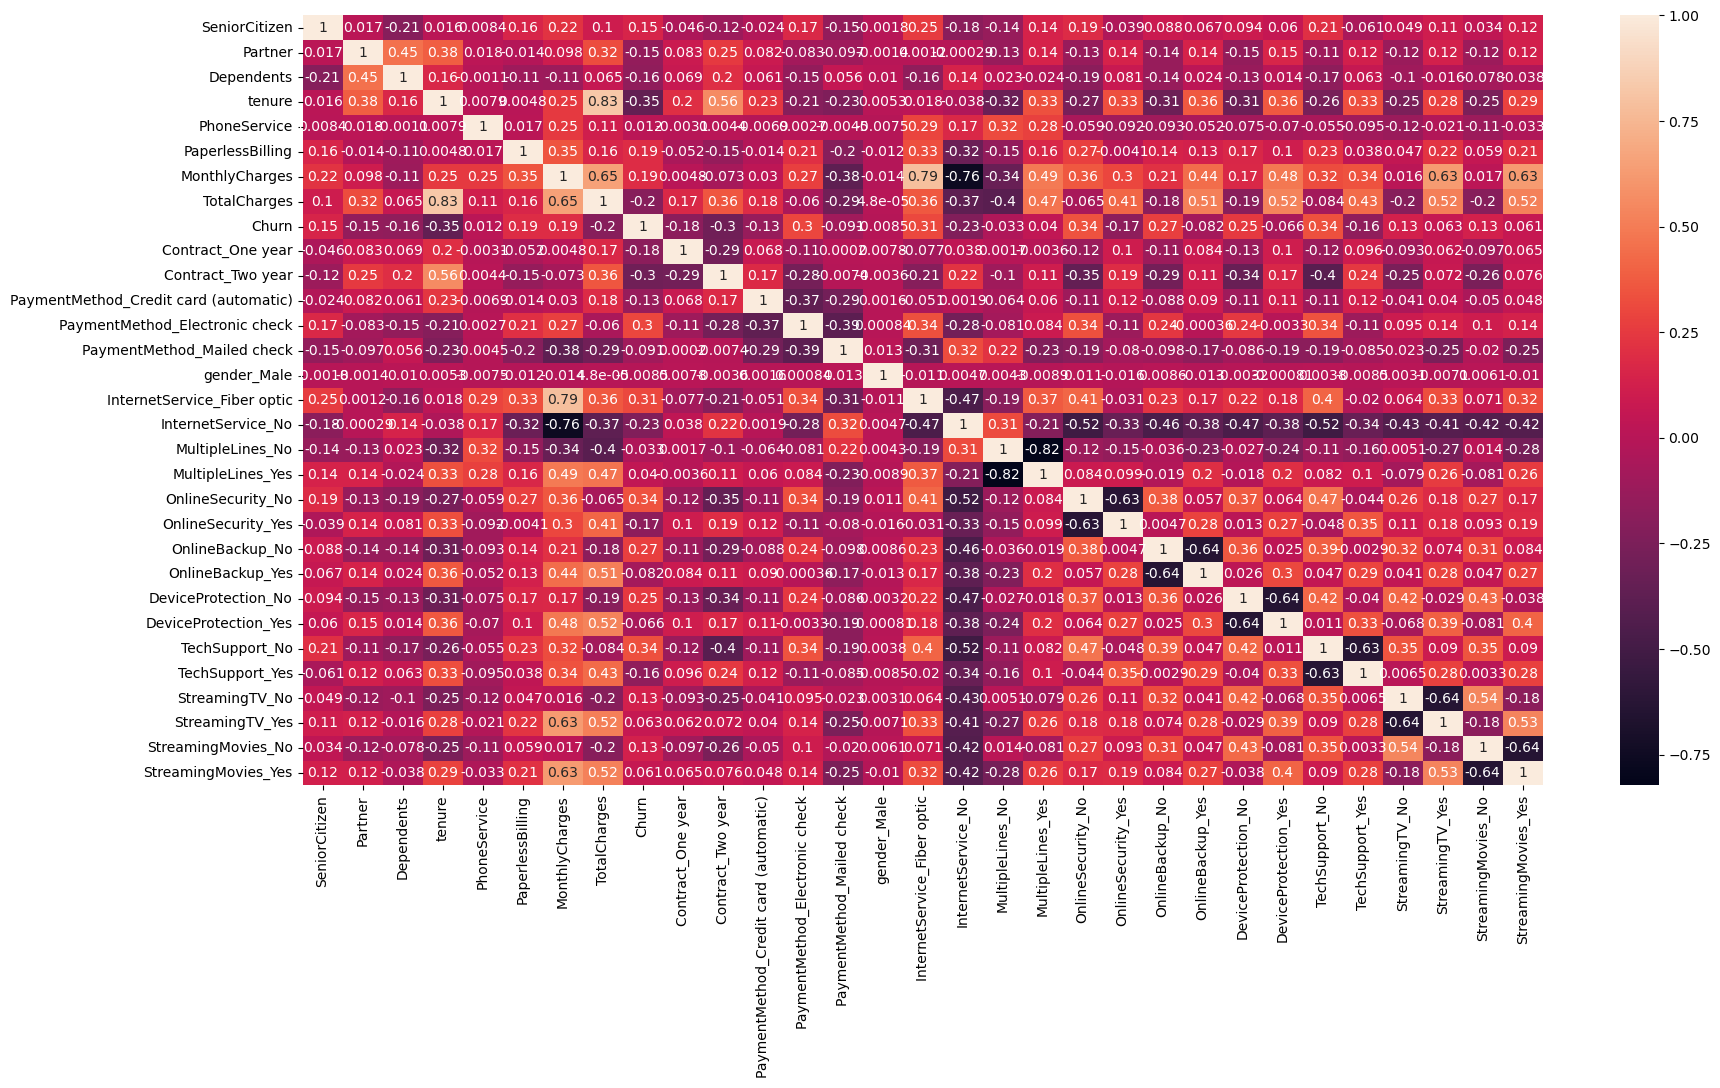

In [30]:
#correlation matrix
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(),annot = True)
plt.show()

In [31]:
#dropping highly correlated columns
X_test = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                       'StreamingTV_No','StreamingMovies_No'], 1)
X_train = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                         'StreamingTV_No','StreamingMovies_No'], 1)

C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1096021196.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
C:\Users\hp\AppData\Local\Temp\ipykernel_20152\1096021196.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',


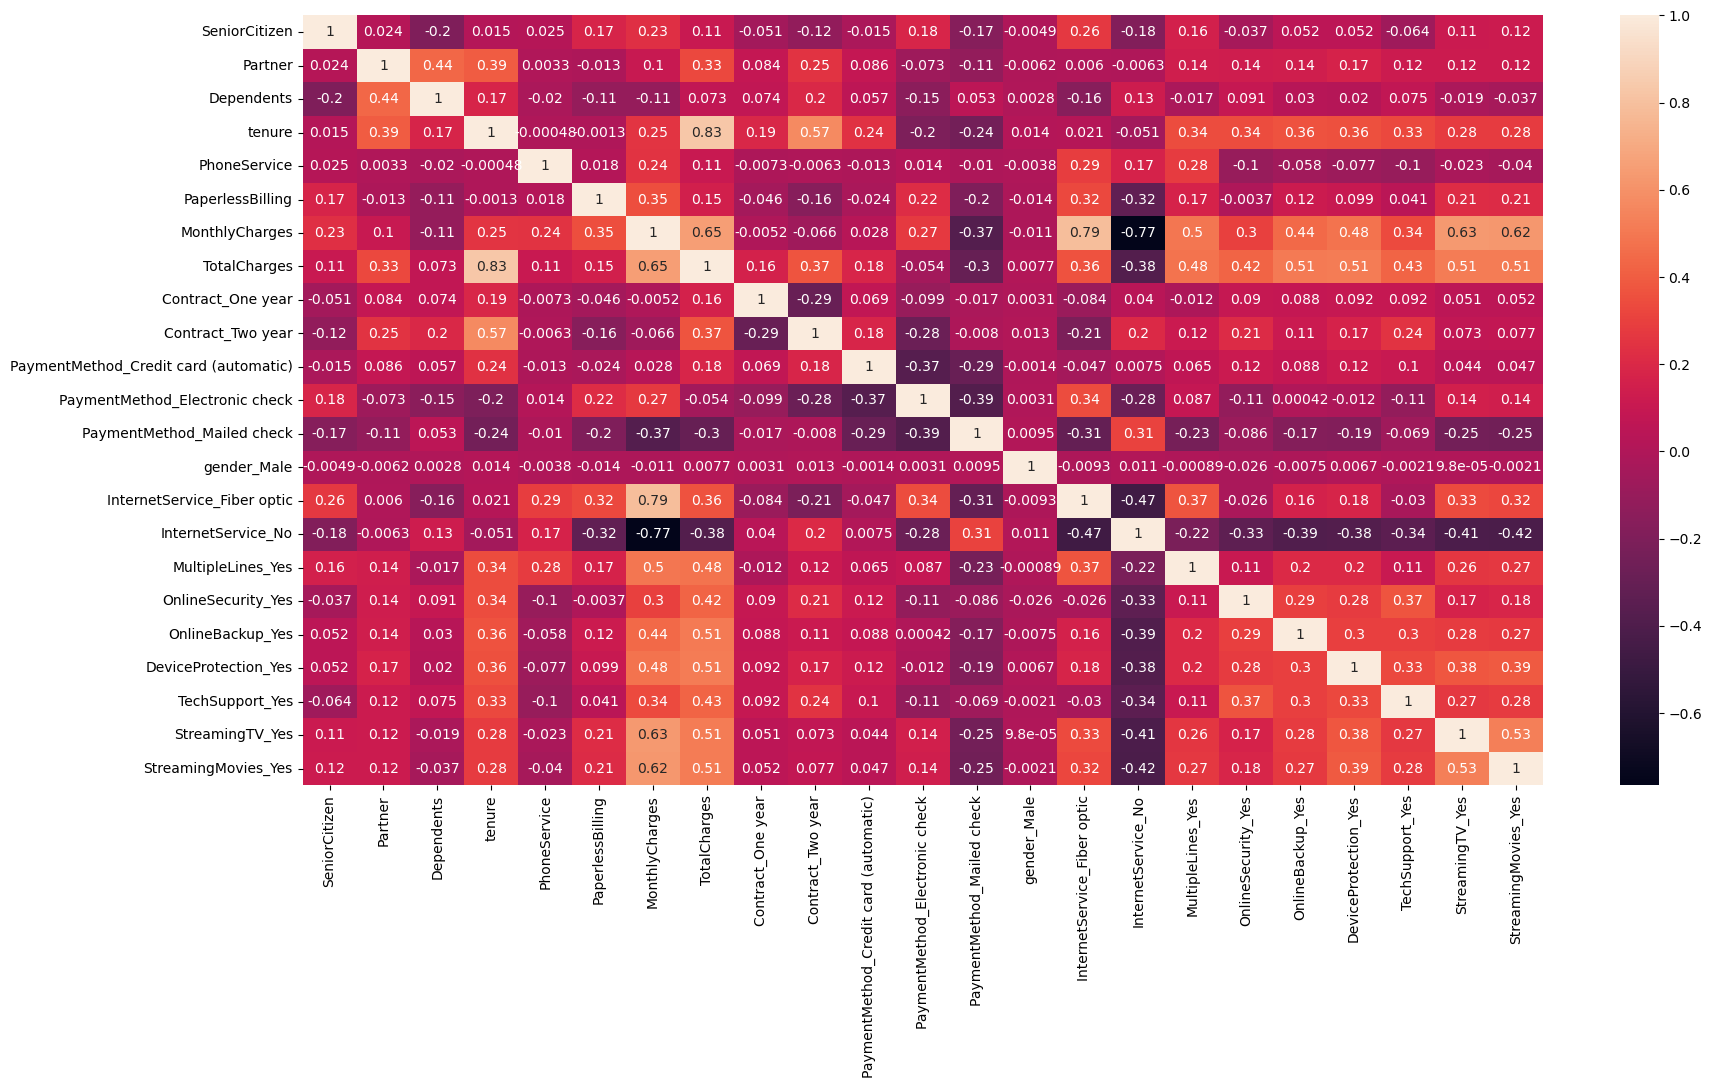

In [32]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

In [35]:
#training logistic regression model using hyper parameter tuning and gridsearch
logModel = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2160 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError:

In [36]:
#finding accuracy
best_clf.score(X_train,y_train)

0.8086143843965867

In [37]:
y_train_pred = best_clf.predict(X_train).reshape(-1)

In [38]:
y_train_pred[:10]

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int64)

In [39]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'predicted':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final['predicted'] = y_train_pred

In [40]:
y_train_pred_final.head()

,Churn,predicted,CustID
0,0,0,879
1,0,0,5790
2,1,1,6498
3,1,0,880
4,1,1,2784


In [41]:
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8086143843965867


In [42]:
#Confusion Matrx of the trained model
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[3273,  362],
       [ 580,  707]], dtype=int64)

In [43]:
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.8086143843965867

In [44]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [45]:
#Metrics other than Accuracy
print("sensitivity: {}".format(TP / float(TP+FN)))
print("specificity: {}".format(TN / float(TN+FP)))
print("FP rate: {}".format(FP/ float(TN+FP)))
print("Positive Predictive Value: {}".format(TP / float(TP+FP)))
print("Negative Predictive Value: {}".format(TN / float(TN+FN)))

sensitivity: 0.5493395493395493
specificity: 0.9004126547455296
FP rate: 0.09958734525447042
Positive Predictive Value: 0.6613657623947614
Negative Predictive Value: 0.8494679470542434


In [46]:
#Plotting ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [47]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.predicted, drop_intermediate = False )

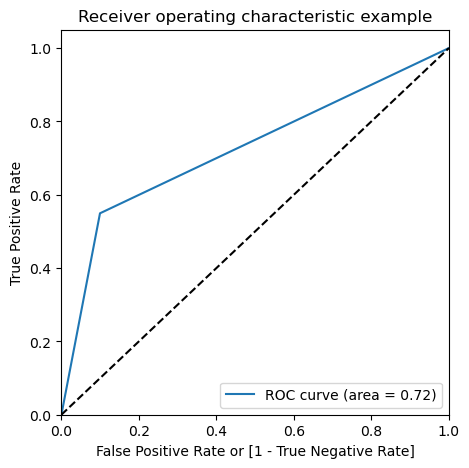

In [48]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.predicted)

In [53]:
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])

In [54]:
#testing the pretrained logisctic regression model
y_test_pred = best_clf.predict(X_test)

In [88]:
y_pred_1 = pd.DataFrame(y_test_pred)


In [56]:
y_test_df = pd.DataFrame(y_test)

In [57]:
y_test_df['CustID'] = y_test_df.index

In [58]:
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [59]:
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [60]:
y_pred_final.head()

,Churn,CustID,0
0,0,942,0
1,1,3730,0
2,0,1761,0
3,1,2283,1
4,0,1872,0


In [61]:
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Predicted'})

In [62]:
y_pred_final.head()

,Churn,CustID,Churn_Predicted
0,0,942,0
1,1,3730,0
2,0,1761,0
3,1,2283,1
4,0,1872,0


In [64]:
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.Churn_Predicted)

0.7985781990521327

In [66]:
confusion2 = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.Churn_Predicted )
confusion2
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [67]:
#test specificity and sensitivity
print("sensitivity: {}".format(TP / float(TP+FN)))
print("specificity: {}".format(TN / float(TN+FP)))

sensitivity: 0.570446735395189
specificity: 0.8854712041884817


# Training a decision tree model

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [69]:
scaler = MinMaxScaler()
X_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
879,0,0,0,0.450704,1,1,0.362189,0.189979,0,0,...,0,1,1,0,1,0,1,0,1,0
5790,0,1,1,0.549296,0,1,0.324378,0.232831,0,0,...,0,1,1,0,1,0,0,1,0,1
6498,0,0,0,0.000000,1,1,0.637313,0.007322,0,0,...,0,1,0,1,1,0,1,0,1,0
880,0,0,0,0.126761,1,1,0.913930,0.118216,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,0,0,1,0.042254,1,1,0.794527,0.043556,0,0,...,1,0,0,1,0,1,0,1,0,1


In [72]:
clf= DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X_train, y_train) 
y_pred= clf.predict(X_train) 

In [73]:
confusion= metrics.confusion_matrix(y_train, y_pred)  

In [74]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [75]:
print("sensitivity: {}".format(TP / float(TP+FN)))
print("specificity: {}".format(TN / float(TN+FP)))

sensitivity: 0.9906759906759907
specificity: 1.0


In [76]:
#test and train scores of decision tree model clearly indicates a overfitted model
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9975619666802112, 0.6890995260663507)

In [77]:
#knowing more about decision tree details
tree_info = clf.tree_
num_nodes = tree_info.node_count
num_leaves = tree_info.n_leaves
num_decision = num_nodes - num_leaves

print("Number of nodes:", num_nodes)
print("Number of leaves:", num_leaves)
print("Number of decision:", num_decision)

Number of nodes: 1909
Number of leaves: 955
Number of decision: 954


In [78]:
#adjusting decision tree parameters to make the model perfectly fit
clf = DecisionTreeClassifier(max_depth = 5, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8033319788703779, 0.7241706161137441)

In [79]:
clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 15, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8031288094270622, 0.7241706161137441)

In [80]:
clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 16, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8031288094270622, 0.7241706161137441)

In [81]:
clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 19, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8031288094270622, 0.7241706161137441)

In [82]:
clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 19, 
min_samples_leaf = 35, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8006907761072735, 0.7241706161137441)

In [83]:
clf = DecisionTreeClassifier(max_depth = 5,  min_samples_split = 19, 
min_samples_leaf = 35, max_leaf_nodes = 6, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7925639983746444, 0.7241706161137441)

In [84]:
clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 20, 
min_samples_leaf = 10, max_leaf_nodes = 6, max_features = "log2", random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7769199512393336, 0.7625592417061612)

In [85]:
y_pred= clf.predict(X_test) 
confusion= metrics.confusion_matrix(y_test, y_pred)  

In [86]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [87]:
print("sensitivity: {}".format(TP / float(TP+FN)))
print("specificity: {}".format(TN / float(TN+FP)))

sensitivity: 0.5446735395189003
specificity: 0.8455497382198953


# After training both logistic regression and decision tree models the maximum possible specificity aquired is 88.9% by Logistic Regression and 84.55% by Decision Tree Algorithm
# While Logistic regression Specificity increased by hyper parameter tuning the decision tree model when fine tuned was overly fitting